In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from plots.utils import compute_user_penalty, get_team_values_df
from common.load import load_competition_data, process_team_logs

# Import common data

In [54]:
config = 'config_vbs2023.yaml'

# load competition data from dres files and auxiliary data (FPSs, sequences)
comp_data = load_competition_data(config)

# compute team logs and put them in the form of dataframes (or load them if already existing)
logs = process_team_logs(config, comp_data, force=False)

teams = comp_data['config']['teams']

/disks/workspace/Workspace/VBS-Analysis/VBS-2022/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/disks/workspace/Workspace/VBS-Analysis/VBS-2022/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/disks/workspace/Workspace/VBS-Analysis/VBS-2022/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/disks/workspace/Workspace/VBS-Analysis/VBS-2022/common/tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
/disks/workspace/Workspace/V

# Analysis

## Time Recall Table

In [55]:
def compute_data_for_time_recall_table(comp_data, teams, logs, split_user=False, only_best_user=False, max_records=10000):
    dfs = []
    for team in teams:
        team_df = logs[team].get_events_dataframe().reset_index()
        team_df = get_team_values_df(comp_data, team_df, split_user if not only_best_user else True, max_records)
        dfs.append(team_df)

    total_df = pd.concat(dfs, axis=0).reset_index()

    # keep the results from the best user among the two, for each given (task, team)
    if only_best_user:
        # the best penalty contribution is given by the ranks. If they are equal, then the user that submitted earlier wins
        user_penalty = compute_user_penalty(total_df, max_records)
                    
        total_df['user_penalty'] = user_penalty
        total_df = total_df.loc[total_df.groupby(['team', 'task'])['user_penalty'].idxmin()]
        total_df = total_df.drop(['user_penalty'], axis=1)
    
    return total_df

def build_table(df, teams, dataset='v3c'):
    # drop unuseful columns
    df = df.drop(['time_first_appearance', 'rank_shot_first_appearance', 'time_last_appearance', 'rank_shot_last_appearance', 'time_first_appearance_video', 'rank_video_first_appearance'], axis=1)

    #renaming task
    rename_fun = lambda x: x.replace('vbs23-kis-t', 'T_').replace('vbs23-kis-v-m', 'M_').replace('vbs23-kis-v', 'V_')
    df['task'] = df['task'].apply(rename_fun)
    tasks = df[['task','task_start']].sort_values(by=['task_start'])['task'].unique()
    textual=[t for t in tasks if t.startswith('T')] #used later to order the column
    visual=[t for t in tasks if t.startswith('V')] #used later to order the column
    marine=[t for t in tasks if t.startswith('M')] #used later to order the column
    df.drop(columns='task_start', inplace=True)

    df = df.fillna(-1)
    col=[c for c in df.columns.values.tolist() if c!='team' and c!='task' and c!='user']
    df[col]= df[col].astype('int32')
    df[col] = df[col].applymap(lambda x: -1 if x< 0 else x)
    df = df.astype('str')
    df.replace(['-1'], '-', inplace=True)

    #aggregate
    agg_dic={c: (lambda x: ' / '.join(x)) for c in col}
    agg_dic['time_correct_submission']="min"
    df=df.groupby(['team','task'])[col].agg(agg_dic).reset_index()
    df.replace('- / -', '-', regex=True, inplace=True)
    add_second= lambda x: x if x=='-' else x + 's'
    df['time_correct_submission']=df['time_correct_submission'].apply(add_second)
    df['time_best_shot']=df['time_best_shot'].apply(add_second)
    # df['rank_shot_margin_5'] = df['rank_shot_margin_5'].apply(add_second)
    df['time_best_video'] = df['time_best_video'].apply(add_second)

    # put ! where no logs are present
    tasks_unique = pd.DataFrame({'task': textual+visual+marine})
    teams_unique = pd.DataFrame({'team': df['team'].unique()})
    task_team = teams_unique.merge(tasks_unique, how='cross')
    df = task_team.merge(df, how='left').fillna('!')

    df = df.melt(var_name="metric", id_vars=["team", "task"], value_name="value")
    df['unit'] = df['metric'].apply(lambda x: 'rank' if x.startswith('rank_') else 'time')
    replace_dic = {
        'rank_shot_margin_0': 'correct frame',
        'time_best_shot': 'correct frame',
        'rank_shot_margin_5': 'frame in GT+2x5s',
        'time_best_shot_margin5': 'frame in GT+2x5s',
        'rank_video': 'correct video',
        'time_best_video': 'correct video',
        'time_correct_submission': 'correct submission'
    }
    df['metric']=df['metric'].map(replace_dic)
    df = df.pivot(index=['team', 'metric', 'unit'], columns="task", values="value")
    df=df.fillna('-')


    #sorting index desired order
    level_0=teams #order in the conf file
    level_1=['correct frame', 'frame in GT+2x5s', 'correct video','correct submission']
    level_2=['rank','time']
    df = df.reindex(pd.MultiIndex.from_product([level_0,level_1,level_2]))
    df.dropna(axis=0, inplace=True)#'correct submission'/rank shluld not be in the index
    df_margin_5 = df.copy()

    # sorting index desired order
    level_0 = teams  # order in teh conf file
    level_1 = ['correct frame', 'correct video', 'correct submission']
    level_2 = ['rank', 'time']
    df = df.reindex(pd.MultiIndex.from_product([level_0, level_1, level_2]))
    df.dropna(axis=0, inplace=True)  # 'correct submission'/rank shluld not be in the index

    #ordering columns
    if dataset == 'v3c':
        df = df[textual+visual]
    elif dataset == 'mvk':
        df = df[marine]
    else:
        # put all
        df = df[textual+visual+marine]
    return df, df_margin_5

In [56]:
df = compute_data_for_time_recall_table(comp_data, teams, logs)
table, table5 = build_table(df, teams, dataset='v3c')
table
# table.to_csv('v3c_rank_table.csv')

task                                 T_1   T_2   T_3   T_4   T_5   T_6   T_7  \
VISIONE    correct frame      rank     1     1     1    16     1     1     4   
                              time   26s   65s  384s   76s   88s   23s   64s   
           correct video      rank     1     1     1    16     1     1     4   
                              time   26s   59s  384s   76s   88s   23s   64s   
           correct submission time   65s   76s     -  111s  100s   52s   95s   
VideoCLIP  correct frame      rank     1  1335     -     -     -    40     !   
                              time   51s  334s     -     -     -  175s     !   
           correct video      rank     1  1335    13    25   904    40     !   
                              time   51s  334s  191s  174s  371s  175s     !   
           correct submission time  283s     -     -  198s     -     -     !   
Verge      correct frame      rank     3    79   638   132    39     3  4453   
                              time   40s  160s  289s  345s  271s  131s   26s   
           correct video      rank     3    79   124   132    14     3    25   
                              time   40s  160s  210s  345s  369s  131s   27s   
           correct submission time  281s     -     -  356s     -  180s  115s   
HTW        correct frame      rank     1     1    12    13     4    16     -   
                              time   28s    6s  277s  140s  104s   21s     -   
           correct video      rank     1     1    12    13     1    16     1   
                              time   28s    6s  277s  140s   79s   21s   23s   
           correct submission time   37s   26s  395s  155s  150s   29s  193s   
VIREO      correct frame      rank     6   141   100    20   201     5     -   
                              time  137s  409s   53s  187s   50s   24s     -   
           correct video      rank     1   141    64    20     6     5     1   
                              time   20s  409s  280s  187s   91s   24s  176s   
           correct submission time  166s     -     -  253s  122s  311s  191s   
vitrivr    correct frame      rank     4     4     2   289     1    81    22   
                              time   23s   78s   32s   88s  110s   26s   39s   
           correct video      rank     2     4     2     7     1    81     1   
                              time   47s   78s   32s   88s  110s   26s   39s   
           correct submission time   94s  219s     -  115s  116s   63s   50s   
vitrivr-VR correct frame      rank     7    14     -     -     -     4     -   
                              time   27s   81s     -     -     -   34s     -   
           correct video      rank     2    14     4    64     3     3     2   
                              time   85s   81s   40s  395s  130s   34s   39s   
           correct submission time  213s     -   93s     -  179s   53s   88s   

task                                 V_1   V_2  V_3   V_4   V_5   V_6  
VISIONE    correct frame      rank     4  3752    2    24    19   224  
                              time   16s   46s  26s   18s   62s  298s  
           correct video      rank     1   106    1    24     1     2  
                              time   16s   87s  26s   18s   65s  163s  
           correct submission time   25s  112s  34s   25s   72s     -  
VideoCLIP  correct frame      rank     -     !    !     !     !     !  
                              time     -     !    !     !     !     !  
           correct video      rank    28     !    !     !     !     !  
                              time   48s     !    !     !     !     !  
           correct submission time   53s     !    !     !     !     !  
Verge      correct frame      rank   518     -  393    82   122     9  
                              time  201s     -  18s   55s   65s  204s  
           correct video      rank    17    86    2    82   122     2  
                              time  201s   33s  25s   55s   65s  120s  
           correct submission time  222

In [57]:
# exclude videoclip and VERGE that have not logged MVK
df_filtered = df[~df['team'].isin(['VideoCLIP', 'Verge'])]

table, table5 = build_table(df_filtered, teams, dataset='mvk')
table
# table.to_csv('mvk_rank_table.csv')

task                                M_1   M_2   M_3   M_4   M_5  M_7
VISIONE    correct frame      rank    6    80    17    33    27    2
                              time  23s  205s   12s  245s   19s  37s
           correct video      rank    4    80    17    33    27    1
                              time  23s  205s   12s  245s   19s  12s
           correct submission time  76s  254s   27s  266s   51s  44s
HTW        correct frame      rank    8     4     6     5    41    3
                              time  16s   30s   15s   94s   23s  11s
           correct video      rank    8     1     3     5    41    1
                              time  16s   30s   15s   94s   23s  11s
           correct submission time  27s   46s   24s  211s   53s  23s
VIREO      correct frame      rank  132    78   216   188   198    5
                              time  16s   20s   16s  101s  219s   7s
           correct video      rank   26    78    40   188   198    4
                              time  16s   20s   72s  101s  219s   7s
           correct submission time  43s  110s  101s  183s     -  11s
vitrivr    correct frame      rank    -     -     -     -     -    -
                              time    -     -     -     -     -    -
           correct video      rank   46    24     6   641    16    1
                              time  21s  201s  179s  219s   38s  16s
           correct submission time  80s     -  196s     -   56s  22s
vitrivr-VR correct frame      rank  105    12    44  1201   546    1
                              time  13s  161s  160s   33s   66s  16s
           correct video      rank   99    12    44   171   546    1
                              time  15s  161s  160s  215s   66s  16s
           correct submission time  38s  270s   62s  265s  102s  26s

In [58]:
def compute_data_for_best_shot_rank(
    data,
    teams,
    logs,
    split_user=False,
    max_records=10000,
    aggregate_users_for=[]):
    """
    Returns the view of the data interesting for the best_shot rank analysis, in the form of a Pandas dataframe
    """
    # self.max_records = max_records
    # self.best_user_policy = best_user_policy
    # self.where_missing_data_is = max_records * 2

    dfs = []
    for team in teams:
        team_df = logs[team].get_events_dataframe().reset_index()
        if team in aggregate_users_for:
        # these teams have undistinguishable physical users, given that their logs are taken from DRES
            team_df['user'] = 0
        team_df = get_team_values_df(data, team_df, split_user, max_records)
        dfs.append(team_df)

    total_df = pd.concat(dfs, axis=0).reset_index()

    view = total_df[total_df["rank_shot_margin_0"] != -1].groupby(['team', 'user']).agg('count')['rank_shot_margin_0']
    print(view)

    user_penalty = compute_user_penalty(total_df, max_records)
                
    total_df['user_penalty'] = user_penalty
    total_df['best_user'] = 1
    total_df.loc[total_df.groupby(['team', 'task'])['user_penalty'].idxmin(), 'best_user'] = 0
    total_df = total_df.drop(['user_penalty'], axis=1)

    return total_df

def build_best_rank_boxplot(
    df, 
    figsize=[7, 6], 
    show_boxplot=True, 
    swarmplot=True, 
    exclude_teams=[], 
    best_user_policy=True,
    where_missing_data_is=20000,
    max_records=1000,
    fill_missing=False):
    """
    Render the dataframe into a table or into a nice graph
    """

    # if fill_missing, missing datapoints are set in some random lines after max_records + k
    if fill_missing:
        # choices = [self.where_missing_data_is, self.where_missing_data_is * 10**(0.1)] #, self.where_missing_data_is * 10**(0.2)]
        df.sort_values(by=['rank_shot_margin_0'])
        df.loc[df['rank_shot_margin_0'] == -1, 'rank_shot_margin_0'] = np.random.uniform(
            where_missing_data_is * 10**(-0.15), 
            where_missing_data_is * 10**(0.15),
            len(df.loc[df['rank_shot_margin_0'] == -1]))
        # total_df["rank_shot_margin_0"] = total_df["rank_shot_margin_0"].loc.replace({-1: max_records + 10000})

    # select only r_s
    df = df[["rank_shot_margin_0", "team", "user", "best_user", "task"]]

    # filter out unwanted teams
    df = df[~df["team"].isin(exclude_teams)]

    # discard NaN values
    df = df[df["rank_shot_margin_0"] != -1]

    # rename users column for better visualization
    df['user'] = df['user'].replace({0: '1st', 1: '2nd'})

    # df = df.pivot(columns="team", values="r_s")
    # print(df)

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=figsize)
    ax.set_yscale("log")
    r = list(range(0, int(math.log10(max_records))))
    r = r + [r[-1] + 1]
    ax.set_yticks([10**x for x in r] + [where_missing_data_is])
    ax.set_yticklabels(['1' if x==0 else '10' if x==1 else f'10$^{x}$' for x in r] + [f'>10$^{r[-1]}$'])

    ax.axhline(y=where_missing_data_is, linewidth=17, color='r', alpha=0.2)

    # Plot the orbital period with horizontal boxes
    if show_boxplot:
        sns.boxplot(x="team", hue="best_user" if best_user_policy else "user", y="rank_shot_margin_0", data=df,
                    whis=[0, 100], width=.6, palette="vlag")

    # Add in points to show each observation

    if swarmplot:
        sns.swarmplot(x="team", hue="best_user" if best_user_policy else "user", y="rank_shot_margin_0", data=df,
                    size=4, linewidth=.3, dodge=True, alpha=0.4 if show_boxplot else 1.0)
    else:
        sns.stripplot(x="team", hue="best_user" if best_user_policy else "user", y="rank_shot_margin_0", data=df,
                    size=5, linewidth=1, dodge=True, alpha=0.4 if show_boxplot else 1.0)
    
    handles, labels = ax.get_legend_handles_labels()
    if best_user_policy:
        labels[0] = "best"
        labels[1] = "other"
    ax.legend(handles[:2], labels[:2], title="user", loc="lower right") # , ncol=2,)

    # Tweak the visual presentation
    ax.yaxis.grid(True)
    ax.set(ylabel="best shot rank")

team        user
HTW         0       18
            1       18
VIREO       0        6
            1       14
VISIONE     0       19
            1       18
Verge       0       12
VideoCLIP   0        3
vitrivr     0       11
            1       11
vitrivr-VR  0       10
            1        8
Name: rank_shot_margin_0, dtype: int64


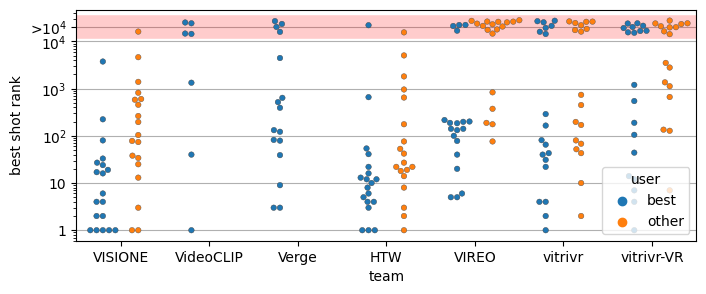

In [59]:
max_records = 10000
df_boxplot = compute_data_for_best_shot_rank(comp_data, teams, logs, max_records=max_records, split_user=True)
build_best_rank_boxplot(df_boxplot, show_boxplot=False, figsize=[8, 3], fill_missing=True, best_user_policy=True, where_missing_data_is=max_records*2, max_records=max_records)
plt.show()

In [60]:
def compute_data_for_browsing_efficiency_scatterplot(data, teams, logs, split_user=True, max_records=1000):
    """
    Returns the view of the data interesting for the current analysis, in the form of a Pandas dataframe
    """

    dfs = []
    for team in teams:
        team_df = logs[team].get_events_dataframe().reset_index()
        df = get_team_values_df(data, team_df, split_user, max_records)
        dfs.append(df)

    total_df = pd.concat(dfs, axis=0).reset_index()

    user_penalty = compute_user_penalty(total_df, max_records)       
    total_df['user_penalty'] = user_penalty
    total_df['best_user'] = 1
    total_df.loc[total_df.groupby(['team', 'task'])['user_penalty'].idxmin(), 'best_user'] = 0
    total_df = total_df.drop(['user_penalty'], axis=1)
    total_df = total_df[total_df["best_user"] == 0] # take only the best user directly

    return total_df

def build_browsing_efficiency_scatterplot(df, time_of='first_appearance', marker_size=5, max_records=1000, figsize=[7, 6], include_incorrect_submissions=False, split_tasks=False, regression_line=False):
    """
    Render the dataframe into a table or into a nice graph
    """
    
    if not include_incorrect_submissions:
        df = df[df["time_correct_submission"] != -1]
    
    # remap time correct_submission
    df["correct_submission"] = (df["time_correct_submission"] >= 0)

    # discard NaN values
    df = df[(df["rank_shot_last_appearance"] != -1) & (df["rank_shot_first_appearance"] != -1)]

    df["elapsed_first_appearance"] = df["time_correct_submission"] - df["time_first_appearance"]
    df["elapsed_last_appearance"] = df["time_correct_submission"] - df["time_last_appearance"]
    first_appearance_df = df[["elapsed_first_appearance", "rank_shot_first_appearance", "team", "task", "correct_submission"]].rename(columns={"elapsed_first_appearance": "elapsed", "rank_shot_first_appearance": "rank_shot"})
    last_appearance_df = df[["elapsed_last_appearance", "rank_shot_last_appearance", "team", "task", "correct_submission"]].rename(columns={"elapsed_last_appearance": "elapsed", "rank_shot_last_appearance": "rank_shot"})
    df = pd.concat([first_appearance_df.assign(dataset='first_appearance'), last_appearance_df.assign(dataset='last_appearance')])

    df["task"] = df["task"].apply(lambda x: 'Textual-KIS' if 'kis-t' in x else ('Visual-KIS-M' if 'm' in x else 'Visual-KIS'))

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=figsize)
    # ax.set_yscale("log")

    if include_incorrect_submissions:
        df.loc[~df["correct_submission"], "elapsed"] = 450

    df = df[df['dataset'] == time_of]

    if split_tasks == "visual":
        df = df[df['task'] == 'Visual-KIS']
    elif split_tasks == "textual":
        df = df[df['task'] == 'Textual-KIS']
    elif split_tasks == "marine":
        df = df[df['task'] == 'Visual-KIS-M']

    print(f"total rows: {len(df)}")

    ax.grid(True)

    # Plot elapsed (time delta) vs rank of first occurrence
    sns.scatterplot(data=df, x="rank_shot", y="elapsed", style="team", hue="task" if split_tasks=="same_graph" else "team", s=marker_size)
    # sns.scatterplot(data=df, x="rank_shot_last_appearance", y="elapsed_last_appearance")

    if regression_line:
        df_regression = df.copy()
        df_regression[~df_regression["correct_submission"]] = np.nan
        sns.regplot(x='rank_shot', y='elapsed', logx=True, scatter_kws={'s':0}, data=df_regression, label="regression line")
        # df_rolling = df_rolling.sort_values(by=["rank_shot"])
        # df_rolling['rolling_elapsed'] = df_rolling['elapsed'].rolling(25, min_periods=2).mean()
        # sns.lineplot(data=df_rolling, x="rank_shot", y="rolling_elapsed")

    if include_incorrect_submissions:
        rang = list(range(0, 500, 100)) + [450]
        ax.set_yticks(rang)
        ax.set_yticklabels(list(map(str,rang[:-1])) + ["NCS"])
        ax.axhline(450, ls='--', alpha=0.3)
        ax.set_ylim(0, 470)

    ax.legend_.remove()

    # Tweak the visual presentation
    ax.set(ylabel="time delta (seconds)", xlabel="shot rank")
    # sns.despine(trim=True, left=True)

    ax.set_xscale('log')
    r = list(range(0, int(math.log10(max_records))))
    r = r + [r[-1] + 1]
    ax.set_xticks([10**x for x in r])
    ax.set_xticklabels(['1' if x==0 else '10' if x==1 else f'10$^{x}$' for x in r])


/tmp/ipykernel_2038019/3365291232.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_first_appearance"] = df["time_correct_submission"] - df["time_first_appearance"]
/tmp/ipykernel_2038019/3365291232.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_last_appearance"] = df["time_correct_submission"] - df["time_last_appearance"]


total rows: 25


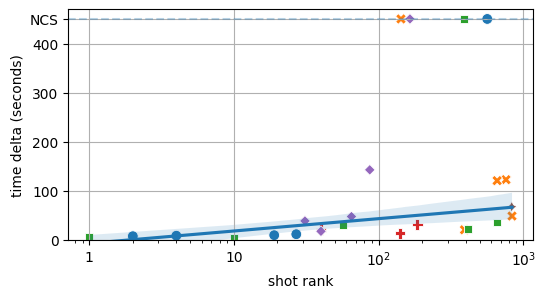

In [61]:
max_records = 1000
df_scatterplot = compute_data_for_browsing_efficiency_scatterplot(comp_data, teams, logs, max_records=max_records, split_user=True)
build_browsing_efficiency_scatterplot(df_scatterplot, time_of='first_appearance', figsize=[6, 3], marker_size=60, include_incorrect_submissions=True, split_tasks="visual", regression_line=True, max_records=max_records)
plt.show()

/tmp/ipykernel_2038019/3365291232.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_first_appearance"] = df["time_correct_submission"] - df["time_first_appearance"]
/tmp/ipykernel_2038019/3365291232.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_last_appearance"] = df["time_correct_submission"] - df["time_last_appearance"]


total rows: 37


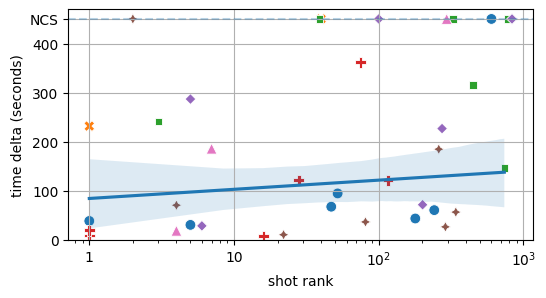

In [62]:
build_browsing_efficiency_scatterplot(df_scatterplot, time_of='first_appearance', figsize=[6, 3], marker_size=60, include_incorrect_submissions=True, split_tasks="textual", regression_line=True, max_records=max_records)
plt.show()

/tmp/ipykernel_2038019/3365291232.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_first_appearance"] = df["time_correct_submission"] - df["time_first_appearance"]
/tmp/ipykernel_2038019/3365291232.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["elapsed_last_appearance"] = df["time_correct_submission"] - df["time_last_appearance"]


total rows: 23


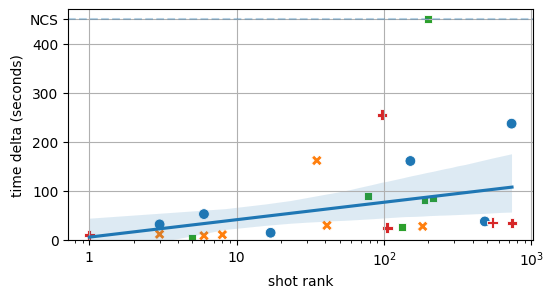

In [63]:
build_browsing_efficiency_scatterplot(df_scatterplot, time_of='first_appearance', figsize=[6, 3], marker_size=60, include_incorrect_submissions=True, split_tasks="marine", regression_line=True, max_records=max_records)
plt.show()